In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, classification_report
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers
import os
import cv2
from tqdm import tqdm

In [2]:
img_size = 200

data_path = "../Data"

datas = os.listdir(os.path.join(data_path, "train"))
images_train = []
images_test = []
images_val = []

class_num = -1
for data in datas:
    class_num += 1
    for img in tqdm(os.listdir(os.path.join(data_path, "train", data)), desc=f"train data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "train", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_train.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    for img in tqdm(os.listdir(os.path.join(data_path, "test", data)), desc=f"test data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "test", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_test.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    for img in tqdm(os.listdir(os.path.join(data_path, "valid", data)), desc=f"val data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "valid", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_val.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    if class_num == 15:
        class_num += 1
        break

val data AMERICAN BITTERN --->: 100%|██████████| 5/5 [00:00<00:00, 320.01it/s]


In [3]:
X_train = []
y_train = []
for data in images_train:
    X_train.append(data["Image"])
    y_train.append(data["Class"])
X_test = []
y_test = []
for data in images_test:
    X_test.append(data["Image"])
    y_test.append(data["Class"])
X_val = []
y_val = []
for data in images_val:
    X_val.append(data["Image"])
    y_val.append(data["Class"])


X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)
X_val = np.array(X_val).reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

In [4]:
y_train_encoded = to_categorical(y_train, num_classes=class_num)
y_test_encoded = to_categorical(y_test, num_classes=class_num)
y_val_encoded = to_categorical(y_test, num_classes=class_num)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(y_train_encoded.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test_encoded.shape)
print(X_val.shape)
print(y_val.shape)
print(y_val_encoded.shape)

(2592, 200, 200, 3)
(2592,)
(2592, 16)
(80, 200, 200, 3)
(80,)
(80, 16)
(80, 200, 200, 3)
(80,)
(80, 16)


In [23]:
img_shape = (img_size, img_size, 3)

# Load pre-trained EfficientNet model
vgg_model = tf.keras.applications.VGG16(include_top=False,
                                        weights='imagenet',
                                        input_shape=img_shape)

# Freeze layers in the base model
for layer in vgg_model.layers:
    layer.trainable = False

# Create a sequential model
model = Sequential()

# Add the base model
model.add(vgg_model)

# Add a global average pooling layer
model.add(layers.GlobalAveragePooling2D())

# Add a flatten layer
model.add(layers.Flatten())

# Add final classification layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(class_num, activation='softmax'))

model.build((None, img_size, img_size, 3))

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Print model summary
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,128 (56.65 MB)

 Trainable params: 135,440 (529.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
model_history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=10, validation_data=(X_val, y_val_encoded))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 246s 12s/step - accuracy: 0.1916 - loss: 2.6345 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4625 - val_loss: 2.1622 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 243s 11s/step - accuracy: 0.4402 - loss: 2.1096 - precision: 0.9545 - recall: 0.0121 - val_accuracy: 0.5375 - val_loss: 1.7662 - val_precision: 1.0000 - val_recall: 0.0500
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 244s 12s/step - accuracy: 0.6087 - loss: 1.7365 - precision: 0.9866 - recall: 0.0838 - val_accuracy: 0.6250 - val_loss: 1.4901 - val_precision: 1.0000 - val_recall: 0.1375
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step - accuracy: 0.6577 - loss: 1.4598 - precision: 0.9803 - recall: 0.1711 - val_accuracy: 0.8000 - val_loss: 1.1765 - val_precision: 1.0000 - val_recall: 0.2250
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 245s 12s/step - accuracy: 0.7172 - loss: 1.2459 - precision: 0.9882 - recall: 0.2713 - val_accuracy: 0.725

In [31]:
prediction = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


In [32]:
pred = np.argmax(prediction, axis=1)

In [37]:
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

Accuracy: 0.8625


In [34]:
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      0.20      0.33         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       0.71      1.00      0.83         5
           9       0.71      1.00      0.83         5
          10       1.00      0.80      0.89         5
          11       1.00      0.80      0.89         5
          12       0.83      1.00      0.91         5
          13       1.00      0.60      0.75         5
          14       1.00      1.00      1.00         5
          15       1.00      0.80      0.89         5

    accuracy                           0.86        80
   macro avg       0.90   

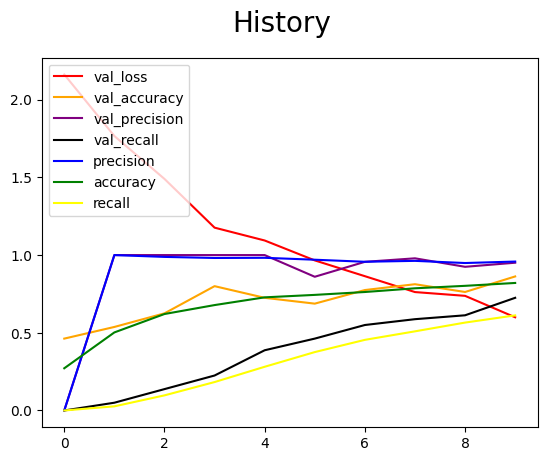

In [35]:
fig = plt.figure()
plt.plot(model_history.history["val_loss"], color='red', label="val_loss")
plt.plot(model_history.history["val_accuracy"], color='orange', label="val_accuracy")
plt.plot(model_history.history["val_precision"], color='purple', label="val_precision")
plt.plot(model_history.history["val_recall"], color='black', label="val_recall")
plt.plot(model_history.history["precision"], color='blue', label="precision")
plt.plot(model_history.history["accuracy"], color='green', label="accuracy")
plt.plot(model_history.history["recall"], color='yellow', label="recall")
fig.suptitle("History", fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [36]:
model.save("../Models/vgg16.h5")